In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import pi

In [2]:
def open_json_as_nparray(json_fname):
    with open(json_fname, 'r') as json_f:
        return np.array(json.load(json_f))

In [3]:
int2char_mm = {
    0 : '#',
    1 : '*',
    2 : '+',
    3 : '-',
    4 : 'B',
    5 : 'C',
    6 : 'D',
    7 : 'H',
    8 : 'L',
    9 : 'M',
    10 : 'P',
    11 : 'U',
    12 : 'W',
    13 : 'l',
    14 : 't',
    15 : 'w',
    16 : '|',
}

## Density

In [4]:
RESULTS_DIR = '/home/yangz2/projects/gmvae_and_gmmvae/results'
GAME = 'mma'
MODEL = 'gmvae'
num_components=10

json_fname = f'{RESULTS_DIR}/{GAME}_{MODEL}_generations/{GAME}_{MODEL}_{num_components}.json'
num_components = int(json_fname.split('_')[-1].split('.')[0])
num_gens_per_comp = 500

In [5]:
chunks_int = open_json_as_nparray(json_fname)
begin, end = 0, num_gens_per_comp
chunks_by_comp = []
for i in range(num_components):
    chunks_by_comp.append(chunks_int[begin:end])
    begin, end = begin + num_gens_per_comp, end + num_gens_per_comp

In [6]:
def get_densities(chunks):
    unique_indices = np.unique(chunks)
    densities = {i:[] for i in unique_indices}
    for idx, chunk in enumerate(chunks):
        for i in unique_indices:
            chunk_mod = chunk == i
            densities[i].append(np.count_nonzero(chunk_mod))
    return [np.mean(v) for k, v in densities.items()]

In [7]:
densities_by_comp = [get_densities(chunks) for chunks in chunks_by_comp]
len(densities_by_comp)

10

In [8]:
df = pd.DataFrame(densities_by_comp)
df = df.fillna(0)
df /= df.max()
df.columns = [int2char_mm[i] for i in np.unique(chunks_int)]
df = df.iloc[:,:-1]
df.head()

,#,*,+,-,B,C,D,H,L,M,P,U,W,l,t,w
0,1.000000,0.238779,0.112045,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.701323,0.000040,0.000070,0.548640,0.110023,0.426036,0.002801,0.249405,0.306931,0.001071,0.779348,0.054264,0.126984,0.046875,0.692308,0.009639
2,0.557292,0.000040,0.000182,0.684414,0.105501,0.254438,0.001120,0.438270,0.316832,0.019869,0.729319,0.031008,0.349206,0.015625,0.230769,0.790964
3,0.684417,0.000040,0.000126,0.548399,0.211002,1.000000,0.027451,0.061297,0.405941,0.004091,1.000000,0.023256,0.079365,0.015625,1.000000,0.030723
4,0.609812,0.000030,0.000210,0.682972,0.136398,0.059172,0.001681,0.142703,0.287129,0.013052,0.580876,0.015504,0.079365,0.203125,0.030769,0.006627


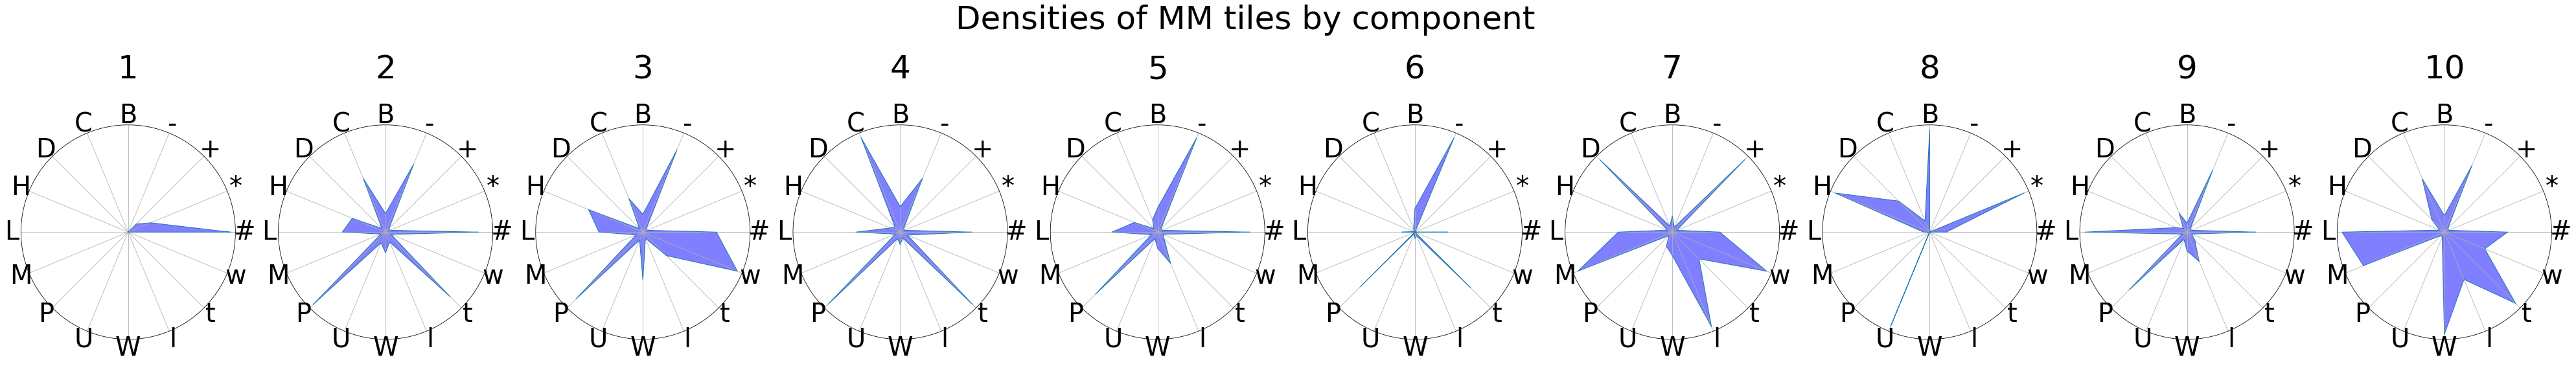

In [9]:
categories = list(df)

fig, axs = plt.subplots(nrows=1, ncols=num_components, figsize=(num_components * 7, 7),
                           subplot_kw=dict(polar=True))
axs = axs.flatten()

for i in range(num_components):
    
    ax = axs[i]
    
    values = df.iloc[i].tolist()
    values += values[:1] # repeat the first value to close the circular graph
    angles = [n / float(len(categories)) * 2 * pi for n in range(len(categories))]
    angles += angles[:1]

    ax.set_xticks(angles)
    ax.set_xticklabels(categories, fontsize=40)
    ax.set_yticks([])
    ax.set_rlabel_position(30)

    ax.plot(angles, values, linewidth=1, linestyle='solid')
    ax.fill(angles, values, 'blue', alpha=0.5)
    
    ax.set_title(f'{i+1}', y=1.20, fontsize=50)

plt.suptitle('Densities of MM tiles by component', y=1.20, fontsize=50)
# plt.tight_layout()
plt.show()

## Plotting generations from each component

In [10]:
import sys
sys.path.append('../../1906-pcgml/pcgml-gmmVae-exp/modules/')
import vglc_with_path_encodings

In [11]:
def get_images(chunks_int):
    images = []
    for chunk in chunks_int:
        images.append(vglc_with_path_encodings.array_to_image([chunk], game='mma')[0])
    return images

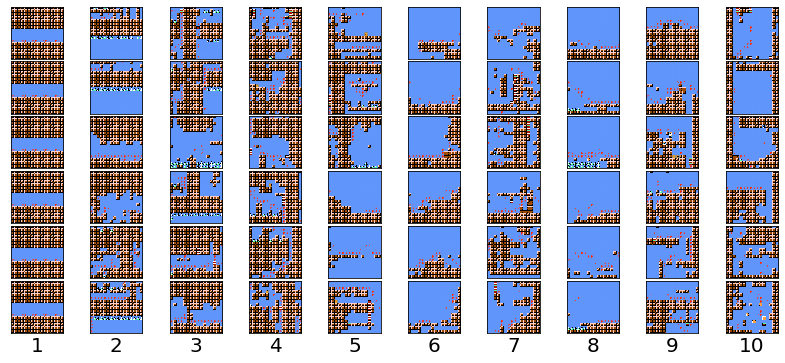

In [15]:
num_rows=6
fig, axs = plt.subplots(num_rows, num_components, figsize=(num_components+4, num_rows))
fig.subplots_adjust(hspace=0.05)
# plt.suptitle('SMB', fontsize=50, y=0.915)
for comp_idx, chunks in enumerate(chunks_by_comp):
    imgs = get_images(chunks[:num_rows])
    for img_idx, img in enumerate(imgs):
        if img_idx == 1:
            pass
#             ax.set_ylabel(f'{comp_idx + 1}', rotation=0, fontsize=50)
            # https://stackoverflow.com/questions/27671748/how-to-print-y-axis-label-horizontally-in-a-matplotlib-pylab-chart
#             ax.yaxis.set_label_coords(-0.5, 0.15)
            # https://stackoverflow.com/questions/37815976/setting-the-position-of-the-ylabel-in-a-matplotlib-graph
        ax = axs[img_idx][comp_idx]
        if img_idx == 5:
            ax.set_xlabel(comp_idx+1, fontsize=20)
        ax.imshow(img)
        ax.set_xticks([])
        ax.set_yticks([])
#         ax.axis('off')
# plt.tight_layout()
plt.savefig(f'MM generations per component (GM-VAE {num_components}).png', dpi=600)